# Notebook Projet Final : Analyse Big Data & Machine Learning avec PySpark

Ce notebook présente une solution pour l'analyse des données "Online Retail". Il suit la méthodologie standard Big Data : Ingestion -> Nettoyage -> Feature Engineering -> Modélisation (Comparaison de modèles).

In [ ]:
# ==============================================================================
# INSTALLATION ET RÉSOLUTION DYNAMIQUE DE JAVA
# ==============================================================================
# 1. Installation de la version Java par défaut (la plus sûre)
!apt-get update -qq
!apt-get install -y default-jre > /dev/null

# 2. Installation de PySpark
!pip install -q pyspark

import os
import subprocess

# 3. Recherche automatique du chemin d'installation exact de Java sur Colab
try:
    # Demande au système Linux où pointe exactement la commande "java"
    java_exec_path = subprocess.check_output(["readlink", "-f", "/usr/bin/java"]).decode("utf-8").strip()

    # Remonte de deux dossiers (depuis /bin/java vers le dossier parent) pour avoir le JAVA_HOME
    java_home = os.path.dirname(os.path.dirname(java_exec_path))

    # Fixation de la variable d'environnement avec le chemin réel trouvé
    os.environ["JAVA_HOME"] = java_home
    print(f"🔍 Chemin Java trouvé dynamiquement : {java_home}")

except Exception as e:
    print("❌ Impossible de trouver Java sur la machine :", e)

# 4. Lancement de PySpark
from pyspark.sql import SparkSession

try:
    spark = SparkSession.builder \
        .appName("Projet_Retail_Expert_Audit") \
        .master("local[*]") \
        .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
        .getOrCreate()
    print("La SparkSession est initialisée .")
except Exception as e:
    print("ERREUR au lancement de Spark :", e)

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
🔍 Chemin Java trouvé dynamiquement : /usr/lib/jvm/java-17-openjdk-amd64
La SparkSession est initialisée .


In [ ]:
import os, sys

os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

# Fix notebook Windows / Py4J
os.environ["PYSPARK_PIN_THREAD"] = "true"

In [ ]:
# Chargement du fichier
# Note : Séparateur ';' et pas d'inférence de schéma immédiate pour gérer les virgules
file_path = "Online_Retail_CSV.csv"

df_raw = spark.read \
    .option("header", "true") \
    .option("delimiter", ";") \
    .csv(file_path)

print("Session Spark active et données chargées.")

Session Spark active et données chargées.


In [ ]:
# --- CHECK STRUCTURE ---
print(f"Nombre de lignes brutes : {df_raw.count()}")
print("Aperçu du schéma brut :")
df_raw.printSchema()
df_raw.show(5)

Nombre de lignes brutes : 541909
Aperçu du schéma brut :
root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)

+---------+---------+--------------------+--------+----------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|     InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+----------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|01/12/2010 08:26|     2,55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|01/12/2010 08:26|     3,39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|01/12/2010 08:26|     2,75|    

In [ ]:
from pyspark.sql.functions import count, when, col, lit

# --- AUDIT DE QUALITÉ (DATA QUALITY CHECK) ---
print("\n--- 1. Analyse des Valeurs Manquantes (Nulls) ---")
# On calcule le pourcentage de valeurs nulles pour chaque colonne
df_raw.select([
    (count(when(col(c).isNull(), c)) / count(lit(1))).alias(c)
    for c in df_raw.columns
]).show()

print(" 'CustomerID' a ~25% de nulls, cela signifie que 1/4 des ventes sont anonymes.")
print("Ces lignes doivent être exclues pour le Clustering Client, mais peuvent être gardées pour l'analyse produit.")



--- 1. Analyse des Valeurs Manquantes (Nulls) ---
+---------+---------+--------------------+--------+-----------+---------+-----------------+-------+
|InvoiceNo|StockCode|         Description|Quantity|InvoiceDate|UnitPrice|       CustomerID|Country|
+---------+---------+--------------------+--------+-----------+---------+-----------------+-------+
|      0.0|      0.0|0.002683107311375157|     0.0|        0.0|      0.0|0.249266943342886|    0.0|
+---------+---------+--------------------+--------+-----------+---------+-----------------+-------+

 'CustomerID' a ~25% de nulls, cela signifie que 1/4 des ventes sont anonymes.
Ces lignes doivent être exclues pour le Clustering Client, mais peuvent être gardées pour l'analyse produit.


In [ ]:
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql.functions import regexp_replace, to_timestamp, col

# ==============================================================================
# 3. NETTOYAGE (DATA CLEANING)
# ==============================================================================
print("\n--- 2. Traitement des Types et Formats ---")

# Problème identifié : Le CSV utilise la virgule ',' pour les décimales (Format Européen)
# Spark attend des points '.' (Format US).
df_cleaned = df_raw \
    .withColumn("Quantity", col("Quantity").cast(IntegerType())) \
    .withColumn("UnitPrice", regexp_replace(col("UnitPrice"), ",", ".").cast(DoubleType())) \
    .withColumn("InvoiceDate", to_timestamp(col("InvoiceDate"), "dd/MM/yyyy HH:mm"))

# --- GESTION DES ANOMALIES MÉTIER ---
# 1. Quantités Négatives : Ce sont souvent des retours ou des annulations.
# Pour une analyse de segmentation (qui sont mes meilleurs clients ?), les retours faussent la donne.
# On compte combien on en a avant de filtrer.
nb_negative = df_cleaned.filter(col("Quantity") < 0).count()
print(f"Nombre de transactions avec quantité négative (Retours) : {nb_negative}")

# 2. Prix Unitaires Zéro : Cadeaux ou erreurs de saisie.
nb_free = df_cleaned.filter(col("UnitPrice") == 0).count()
print(f"Nombre de transactions gratuites : {nb_free}")

# FILTRAGE FINAL
# On ne garde que :
# - Les clients identifiés (CustomerID non null)
# - Les vraies ventes (Quantity > 0)
# - Les vrais prix (UnitPrice > 0)
df_filtered = df_cleaned \
    .filter(col("CustomerID").isNotNull()) \
    .filter(col("Quantity") > 0) \
    .filter(col("UnitPrice") > 0)

print(f"\nVolume après nettoyage  : {df_filtered.count()} lignes valides.")



--- 2. Traitement des Types et Formats ---
Nombre de transactions avec quantité négative (Retours) : 10624
Nombre de transactions gratuites : 2515

Volume après nettoyage  : 397884 lignes valides.


In [ ]:
# --- CELLULE : ANALYSE CARDINALE ---
from pyspark.sql.functions import countDistinct, col, min, max

# On repart du dataframe typé (df_cleaned) créé précédemment
# Rappel : Quantity est Integer, UnitPrice est Double, InvoiceDate est Timestamp

print("--- 1. Volumétrie et Entités Uniques ---")
total_rows = df_cleaned.count()

# Calcul des cardinalités (Nombre de valeurs distinctes)
cardinality = df_cleaned.agg(
    countDistinct("InvoiceNo").alias("Nb_Factures"),
    countDistinct("StockCode").alias("Nb_Produits"),
    countDistinct("CustomerID").alias("Nb_Clients"),
    countDistinct("Country").alias("Nb_Pays")
).collect()[0]

print(f"Total Transactions : {total_rows}")
print(f"Factures uniques   : {cardinality['Nb_Factures']}")
print(f"Produits uniques   : {cardinality['Nb_Produits']}")
print(f"Clients uniques    : {cardinality['Nb_Clients']}")
print(f"Pays représentés   : {cardinality['Nb_Pays']}")

# Ratio Clients/Factures
ratio = cardinality['Nb_Factures'] / cardinality['Nb_Clients']
print(f"Moyenne brute de commandes par client (avant nettoyage) : {ratio:.2f}")

--- 1. Volumétrie et Entités Uniques ---
Total Transactions : 541909
Factures uniques   : 25900
Produits uniques   : 4070
Clients uniques    : 4372
Pays représentés   : 38
Moyenne brute de commandes par client (avant nettoyage) : 5.92


In [ ]:
# --- CELLULE : STATISTIQUES NUMÉRIQUES ---

print("\n--- 2. Distribution des Variables Numériques (Quantity & UnitPrice) ---")

# Calcul de TotalAmount sur df_cleaned pour pouvoir l'inclure dans la description
df_cleaned_with_total = df_filtered.withColumn("TotalAmount", col("Quantity") * col("UnitPrice"))

# A. Statistiques de base (Moyenne, Ecart-type, Min, Max)
# Cela permet de détecter immédiatement les anomalies techniques (Prix < 0 ?)
df_cleaned_with_total.select("Quantity", "UnitPrice", "TotalAmount").describe().show()

# B. Analyse des Quantiles (Plus robuste que la moyenne)
# On regarde le 1%, 25%, 50% (Médiane), 75%, 99%
quantiles_qty = df_cleaned_with_total.approxQuantile("Quantity", [0.01, 0.25, 0.5, 0.75, 0.99], 0.01)
quantiles_price = df_cleaned_with_total.approxQuantile("UnitPrice", [0.01, 0.25, 0.5, 0.75, 0.99], 0.01)

print("Analyse de la Distribution (Quantiles) :")
print(f"Quantité  : 1%={quantiles_qty[0]}, 25%={quantiles_qty[1]}, 50%={quantiles_qty[2]}, 75%={quantiles_qty[3]}, 99%={quantiles_qty[4]}")
print(f"Prix Unit : 1%={quantiles_price[0]}, 25%={quantiles_price[1]}, 50%={quantiles_price[2]}, 75%={quantiles_price[3]}, 99%={quantiles_price[4]}")


--- 2. Distribution des Variables Numériques (Quantity & UnitPrice) ---
+-------+------------------+------------------+------------------+
|summary|          Quantity|         UnitPrice|       TotalAmount|
+-------+------------------+------------------+------------------+
|  count|            397884|            397884|            397884|
|   mean|12.988237777844798| 3.116487755225661|22.396999889417714|
| stddev|179.33177496319988|22.097876630867937|309.07104141401817|
|    min|                 1|             0.001|             0.001|
|    max|             80995|           8142.75|          168469.6|
+-------+------------------+------------------+------------------+

Analyse de la Distribution (Quantiles) :
Quantité  : 1%=1.0, 25%=2.0, 50%=6.0, 75%=12.0, 99%=80995.0
Prix Unit : 1%=0.001, 25%=1.25, 50%=1.95, 75%=3.75, 99%=8142.75


Librairies graphiques initialisées.
--- Visualisation des Distributions (Boxplot & Hist) ---


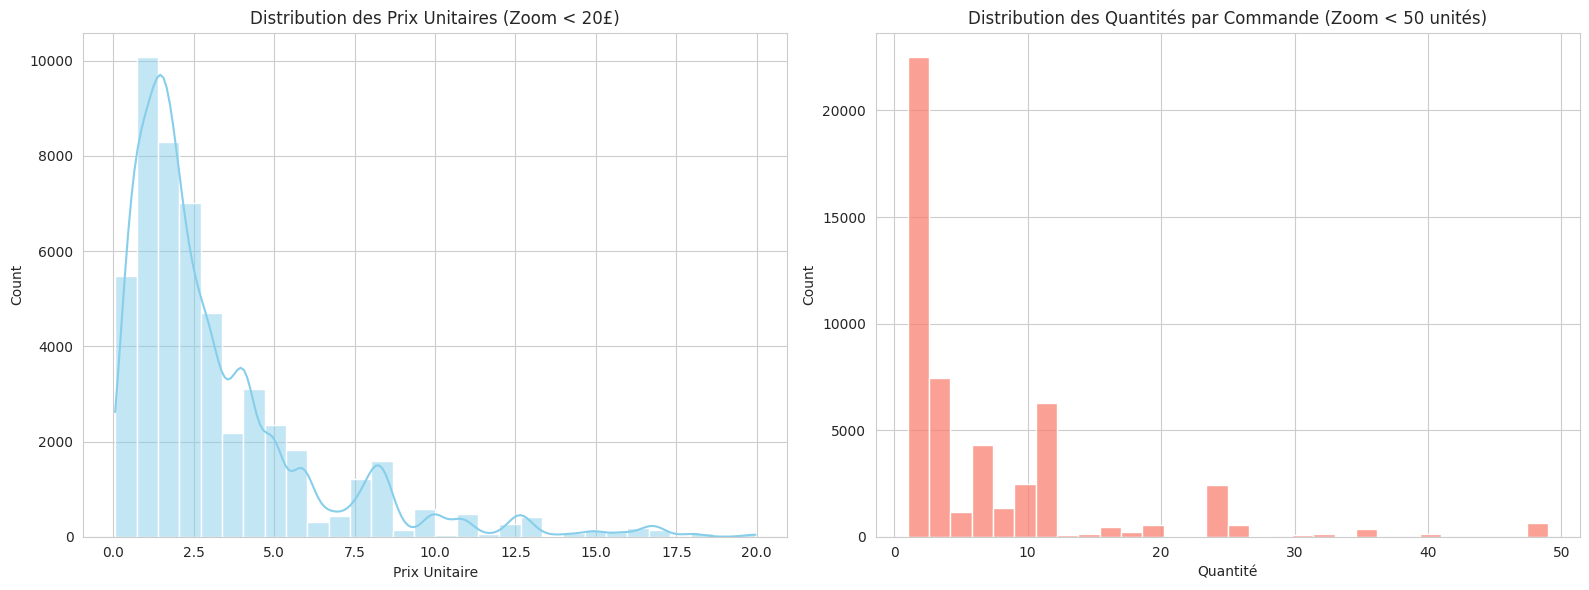

Interprétation  :
1. Les prix suivent une distribution 'Long Tail' (majorité < 5£).
2. Les quantités montrent des pics spécifiques (ex: 6, 12) correspondant aux conditionnements (packs).


In [ ]:
# ==============================================================================
# 2.5 PRÉPARATION À LA VISUALISATION
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Configuration esthétique pour des graphes professionnels
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Librairies graphiques initialisées.")

# ==============================================================================
# 2.6 ANALYSE UNIVARIÉE : DISTRIBUTION DES PRIX ET QUANTITÉS
# ==============================================================================
print("--- Visualisation des Distributions (Boxplot & Hist) ---")

# Les données E-commerce sont très écrasées (beaucoup de petites valeurs, quelques énormes).
# Pour voir quelque chose, on va filtrer les outliers extrêmes juste pour le graphique.
# On utilise le quantile 99% calculé précédemment (~12 pour prix, ~100 pour qté)

# On prend un échantillon de 10% pour aller vite, et on filtre les extrêmes pour la lisibilité
sample_df = df_cleaned.sample(False, 0.1, seed=42).toPandas()

# Filtrage pour la visualisation (On enlève le top 1% et les valeurs négatives)
viz_data = sample_df[
    (sample_df['Quantity'] > 0) &
    (sample_df['Quantity'] < 50) &  # Zoom sur les achats "normaux"
    (sample_df['UnitPrice'] > 0) &
    (sample_df['UnitPrice'] < 20)   # Zoom sur les produits "courants"
]

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1 : Distribution des Prix Unitaires
sns.histplot(viz_data['UnitPrice'], bins=30, kde=True, color='skyblue', ax=ax[0])
ax[0].set_title('Distribution des Prix Unitaires (Zoom < 20£)')
ax[0].set_xlabel('Prix Unitaire')

# Plot 2 : Distribution des Quantités
sns.histplot(viz_data['Quantity'], bins=30, kde=False, color='salmon', ax=ax[1])
ax[1].set_title('Distribution des Quantités par Commande (Zoom < 50 unités)')
ax[1].set_xlabel('Quantité')

plt.tight_layout()
plt.show()

print("Interprétation  :")
print("1. Les prix suivent une distribution 'Long Tail' (majorité < 5£).")
print("2. Les quantités montrent des pics spécifiques (ex: 6, 12) correspondant aux conditionnements (packs).")

/tmp/ipython-input-3660128152.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Period', y='Monthly_Revenue', data=monthly_sales, ax=ax[1], palette="Blues_d")


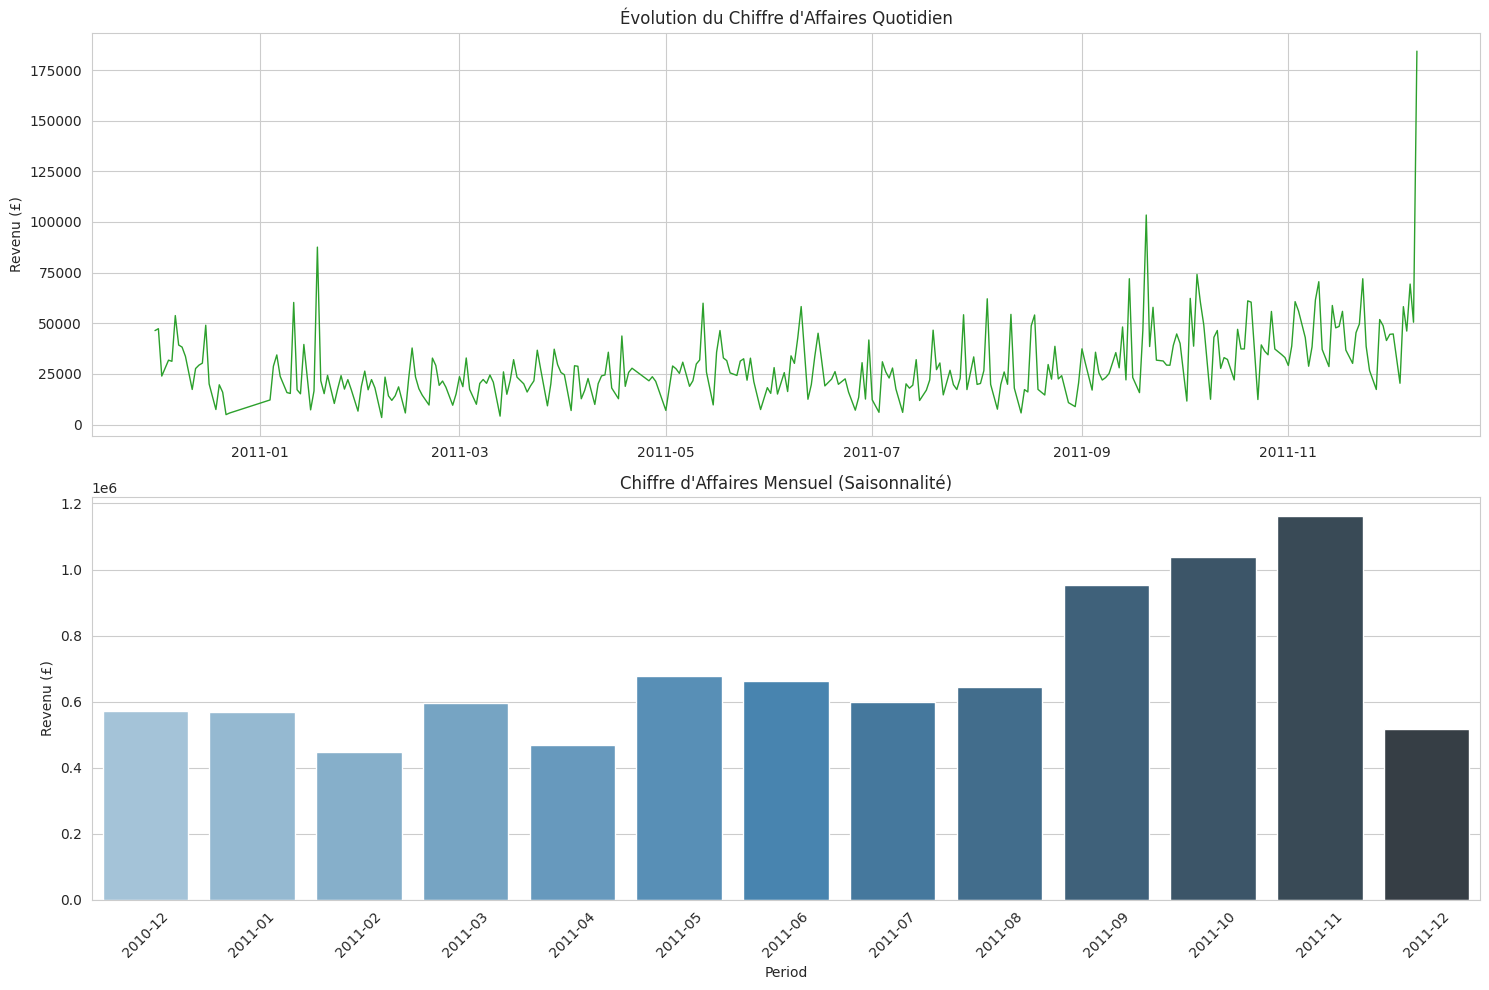

In [ ]:
# ==============================================================================
# 2.7 ANALYSE TEMPORELLE (TIME SERIES)
# ==============================================================================
from pyspark.sql.functions import to_date, date_format, sum, count, year, month

# Agrégation par Jour (Côté Spark pour la rapidité)
daily_sales = df_cleaned_with_total.groupBy(to_date("InvoiceDate").alias("Date")) \
    .agg(sum("TotalAmount").alias("Daily_Revenue"), count("InvoiceNo").alias("Daily_Orders")) \
    .orderBy("Date") \
    .toPandas()

# Agrégation par Mois (Pour voir la tendance macro)
monthly_sales = df_cleaned_with_total.groupBy(year("InvoiceDate").alias("Year"), month("InvoiceDate").alias("Month")) \
    .agg(sum("TotalAmount").alias("Monthly_Revenue")) \
    .orderBy("Year", "Month") \
    .toPandas()

# Création d'une colonne "Periode" propre pour l'affichage
monthly_sales['Period'] = monthly_sales['Year'].astype(str) + '-' + monthly_sales['Month'].astype(str).str.zfill(2)

fig, ax = plt.subplots(2, 1, figsize=(15, 10))

# Graphique 1 : Ventes Quotidiennes
ax[0].plot(daily_sales['Date'], daily_sales['Daily_Revenue'], color='#2ca02c', linewidth=1)
ax[0].set_title('Évolution du Chiffre d\'Affaires Quotidien')
ax[0].set_ylabel('Revenu (£)')

# Graphique 2 : Ventes Mensuelles
sns.barplot(x='Period', y='Monthly_Revenue', data=monthly_sales, ax=ax[1], palette="Blues_d")
ax[1].set_title('Chiffre d\'Affaires Mensuel (Saisonnalité)')
ax[1].set_ylabel('Revenu (£)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


/tmp/ipython-input-1002950982.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Revenue', y='Country', data=row_sales.head(10), palette="viridis")


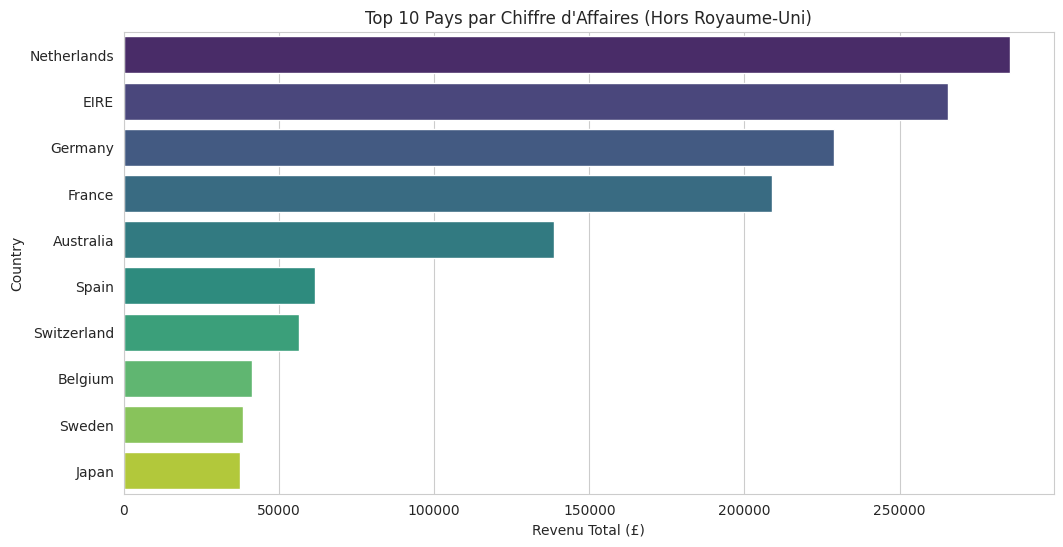

Info Clé : Le Royaume-Uni représente à lui seul 7,308,392 £.
Le graphique ci-dessus permet d'identifier les marchés secondaires prioritaires (ex: France, Allemagne, EIRE).


In [ ]:
# ==============================================================================
# 2.8 ANALYSE GÉOGRAPHIQUE (PARETO)
# ==============================================================================
from pyspark.sql import functions as F

# Calcul du CA par pays
country_sales = df_cleaned_with_total.groupBy("Country") \
    .agg(F.sum("TotalAmount").alias("Revenue")) \
    .orderBy(F.desc("Revenue")) \
    .toPandas()

# On sépare UK (souvent 90% du CA) du reste pour que le graphique soit lisible
uk_sales = country_sales[country_sales['Country'] == 'United Kingdom']['Revenue'].sum()
row_sales = country_sales[country_sales['Country'] != 'United Kingdom']

# Graphique : Top 10 Pays hors UK
plt.figure(figsize=(12, 6))
sns.barplot(x='Revenue', y='Country', data=row_sales.head(10), palette="viridis")
plt.title('Top 10 Pays par Chiffre d\'Affaires (Hors Royaume-Uni)')
plt.xlabel('Revenu Total (£)')
plt.show()

print(f"Info Clé : Le Royaume-Uni représente à lui seul {uk_sales:,.0f} £.")
print("Le graphique ci-dessus permet d'identifier les marchés secondaires prioritaires (ex: France, Allemagne, EIRE).")

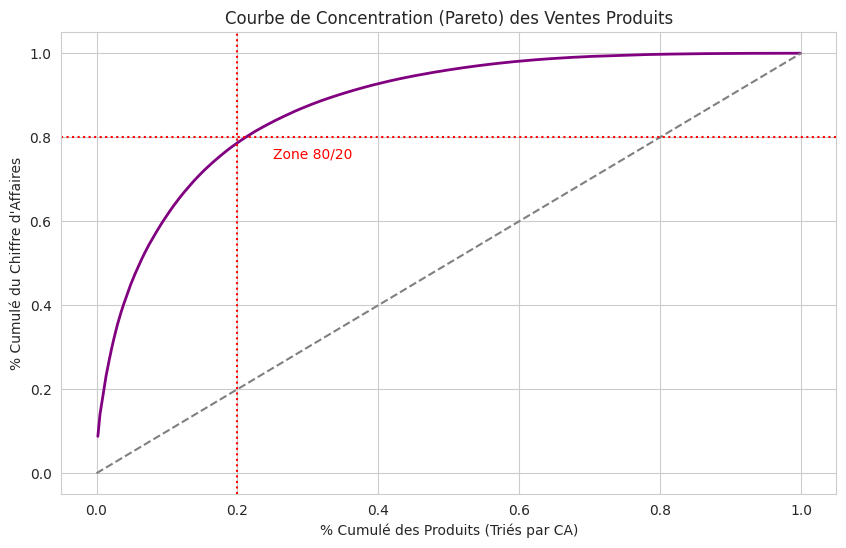

Interprétation  :
La courbe violette monte très vite (ex: elle atteint 0.8 en Y alors qu'on est à 0.2 en X),
cela confirme la règle des 80/20 : une minorité de produits assure la majorité du CA.
Action : Sécuriser le stock de ces 'Top Produits' absolument.


In [ ]:
# ==============================================================================
# 2.9 ANALYSE PRODUIT (PARETO / LONG TAIL)
# ==============================================================================
from pyspark.sql.window import Window
from pyspark.sql.functions import percent_rank, cume_dist

# 1. Calcul du CA par produit
product_sales = df_cleaned_with_total.groupBy("StockCode") \
    .agg(sum("TotalAmount").alias("Product_Revenue"))

# 2. Calcul de la distribution cumulative (Spark Window Functions)
# On trie les produits du plus vendu au moins vendu
window_spec = Window.orderBy(F.desc("Product_Revenue"))
product_pareto = product_sales \
    .withColumn("Cumulative_Revenue", sum("Product_Revenue").over(window_spec)) \
    .withColumn("Total_Revenue_Global", sum("Product_Revenue").over(Window.partitionBy())) \
    .withColumn("Revenue_Percent", col("Cumulative_Revenue") / col("Total_Revenue_Global")) \
    .withColumn("Product_Percent", percent_rank().over(window_spec))

# On convertit en Pandas pour le tracé (on peut sampler si trop de produits)
pareto_pdf = product_pareto.select("Product_Percent", "Revenue_Percent").sample(False, 0.1, seed=42).toPandas()

# 3. Visualisation de la courbe de Lorenz
plt.figure(figsize=(10, 6))
plt.plot(pareto_pdf['Product_Percent'], pareto_pdf['Revenue_Percent'], color='purple', linewidth=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') # Ligne d'égalité parfaite
plt.axhline(y=0.8, color='r', linestyle=':')
plt.axvline(x=0.2, color='r', linestyle=':')

plt.title('Courbe de Concentration (Pareto) des Ventes Produits')
plt.xlabel('% Cumulé des Produits (Triés par CA)')
plt.ylabel('% Cumulé du Chiffre d\'Affaires')
plt.text(0.25, 0.75, 'Zone 80/20', color='red')
plt.show()

print("Interprétation  :")
print("La courbe violette monte très vite (ex: elle atteint 0.8 en Y alors qu'on est à 0.2 en X),")
print("cela confirme la règle des 80/20 : une minorité de produits assure la majorité du CA.")
print("Action : Sécuriser le stock de ces 'Top Produits' absolument.")


In [ ]:
# --- CELLULE SUPPLÉMENTAIRE : DÉTERMINATION DES TOP PRODUITS (Règle 80/20) ---

# Filtrer les produits qui représentent les 20% les plus performants en termes de revenu
# et qui, ensemble, contribuent à au moins 80% du revenu total.
# (On utilise un seuil légèrement supérieur à 0.2 pour Product_Percent pour capturer la zone)
top_products_80_20 = product_pareto.filter(
    (col("Revenue_Percent") <= 0.8) & (col("Product_Percent") <= 0.2)
).orderBy(F.desc("Product_Revenue"))

print("\n--- Top Produits (selon la règle 80/20) ---")
print(f"Nombre de produits représentant les 20% les plus performants: {top_products_80_20.count()}")
top_products_80_20.select("StockCode", "Product_Revenue", "Revenue_Percent", "Product_Percent").show(20, truncate=False)

print("Ces produits sont les articles clés qui nécessitent une attention particulière pour la gestion des stocks et les stratégies marketing.")


--- Top Produits (selon la règle 80/20) ---
Nombre de produits représentant les 20% les plus performants: 733
+---------+------------------+--------------------+---------------------+
|StockCode|Product_Revenue   |Revenue_Percent     |Product_Percent      |
+---------+------------------+--------------------+---------------------+
|23843    |168469.6          |0.018904936438200733|0.0                  |
|22423    |142592.94999999966|0.0349061061227345  |2.729257641921397E-4 |
|85123A   |100603.49999999953|0.04619539969831442 |5.458515283842794E-4 |
|85099B   |85220.78000000044 |0.055758510367027926|8.187772925764192E-4 |
|23166    |81416.72999999998 |0.06489474684919533 |0.001091703056768559 |
|POST     |77803.95999999999 |0.07362557376657575 |0.0013646288209606986|
|47566    |68844.33000000006 |0.0813509894070267  |0.0016375545851528383|
|84879    |56580.34000000046 |0.08770019265409201 |0.001910480349344978 |
|M        |53779.93000000001 |0.0937351458937322  |0.002183406113537118 |
|

In [ ]:
# ==============================================================================
# 4. FEATURE ENGINEERING SOCLE (ENRICHISSEMENT)
# ==============================================================================
# Nous créons ici les variables qui serviront à TOUS les modèles (Clustering et Supervisé)

# Import temporal functions
from pyspark.sql.functions import year, month, hour

# A. Variables Financières
df_enhanced = df_filtered.withColumn("TotalAmount", col("Quantity") * col("UnitPrice"))

# B. Variables Temporelles (Pour l'analyse de saisonnalité)
df_enhanced = df_enhanced \
    .withColumn("Year", year("InvoiceDate")) \
    .withColumn("Month", month("InvoiceDate")) \
    .withColumn("Hour", hour("InvoiceDate"))

print("\nAperçu des données enrichies :")
df_enhanced.select("InvoiceNo", "Description", "Quantity", "TotalAmount", "Country", "Hour").show(5)


Aperçu des données enrichies :
+---------+--------------------+--------+------------------+--------------+----+
|InvoiceNo|         Description|Quantity|       TotalAmount|       Country|Hour|
+---------+--------------------+--------+------------------+--------------+----+
|   536365|WHITE HANGING HEA...|       6|15.299999999999999|United Kingdom|   8|
|   536365| WHITE METAL LANTERN|       6|             20.34|United Kingdom|   8|
|   536365|CREAM CUPID HEART...|       8|              22.0|United Kingdom|   8|
|   536365|KNITTED UNION FLA...|       6|             20.34|United Kingdom|   8|
|   536365|RED WOOLLY HOTTIE...|       6|             20.34|United Kingdom|   8|
+---------+--------------------+--------+------------------+--------------+----+
only showing top 5 rows


In [ ]:
# ==============================================================================
# 5. STRATÉGIE DE SEGMENTATION (RFM + CLUSTERING AVANCÉ)
# ==============================================================================
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.clustering import BisectingKMeans, GaussianMixture, KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import datediff, count, sum, max, lit # Added datediff, count, sum, max, lit

print("\n--- 3. Construction de la Matrice RFM (Recency, Frequency, Monetary) ---")

# Définition du point de référence "Aujourd'hui" (Max Date + 1 jour)
max_date = df_enhanced.agg(max("InvoiceDate")).collect()[0][0]

# Agrégation par Client
rfm_df = df_enhanced.groupBy("CustomerID").agg(
    datediff(lit(max_date), max("InvoiceDate")).alias("Recency"), # Jours depuis dernier achat
    count("InvoiceNo").alias("Frequency"),                        # Fidélité (Nb Commandes)
    sum("TotalAmount").alias("Monetary")                          # Valeur (Chiffre d'affaires)
)



--- 3. Construction de la Matrice RFM (Recency, Frequency, Monetary) ---


In [ ]:
# --- PRÉPARATION ML (Standardisation) ---
#  K-Means et GMM sont sensibles à la variance.
# Monetary (~1000€) écraserait Frequency (~5). Le scaling est OBLIGATOIRE.
assembler = VectorAssembler(inputCols=["Recency", "Frequency", "Monetary"], outputCol="features_raw")
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=True)

pipeline_prep = Pipeline(stages=[assembler, scaler])
model_prep = pipeline_prep.fit(rfm_df)
data_scaled = model_prep.transform(rfm_df)



In [ ]:
# ==============================================================================
# 6. COMPARAISON DES ALGORITHMES (BOUCLE D'OPTIMISATION)
# ==============================================================================
# Nous allons tester 2 algorithmes avancés : BisectingKMeans (Hiérarchique) et GMM (Probabiliste)
# Sur une plage de K allant de 2 à 7.

from pyspark.sql.functions import countDistinct # Import for checking distinct clusters
import builtins # Import builtins module to access original max function

evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol="features", metricName="silhouette")
results_clustering = []

print("\n--- Démarrage de l'Optimisation des Hyperparamètres ---")

for k in range(2, 7):
    # A. Bisecting K-Means (Top-Down Hierarchical)
    # Souvent plus stable que K-Means pour des clusters de tailles inégales
    bkm = BisectingKMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model_bkm = bkm.fit(data_scaled)
    preds_bkm = model_bkm.transform(data_scaled)

    num_distinct_bkm_clusters = preds_bkm.select(countDistinct("prediction")).collect()[0][0]

    sil_bkm = float('-inf') # Default to a very low score if cannot compute
    if num_distinct_bkm_clusters > 1:
        sil_bkm = evaluator.evaluate(preds_bkm)
        print(f"K={k} | Bisecting K-Means Silhouette: {sil_bkm:.4f}", end=" | ")
    else:
        print(f"K={k} | Bisecting K-Means Silhouette: N/A (only {num_distinct_bkm_clusters} cluster found)", end=" | ")

    # B. Gaussian Mixture Model (GMM)
    # Permet des clusters elliptiques (soft clustering)
    gmm = GaussianMixture().setK(k).setSeed(1).setFeaturesCol("features")
    model_gmm = gmm.fit(data_scaled)
    # GMM s'évalue souvent par la LogLikelihood (Vraisemblance)
    log_likelihood = model_gmm.summary.logLikelihood

    results_clustering.append((k, sil_bkm, log_likelihood))
    print(f"GMM LogLikelihood: {log_likelihood:.2f}")

# --- Correction de la sélection optimale ---
# Nous devons ignorer les résultats où le score de Silhouette était non calculable (i.e., -inf)
# Si GMM est le seul à fonctionner, nous choisirons le K qui maximise la LogLikelihood pour GMM.
# Pour simplifier, nous allons choisir le K qui a la meilleure LogLikelihood pour GMM car BisectingKMeans n'a pas produit de clusters valides.

# Filtrer les résultats valides de GMM pour trouver le meilleur K
gmm_results = [(k, ll) for k, sil, ll in results_clustering if ll != float('-inf')]
if gmm_results:
    best_gmm_config = builtins.max(gmm_results, key=lambda x: x[1])
    best_k_gmm = best_gmm_config[0]
    print(f"\n-> Configuration Optimale retenue (basée sur GMM LogLikelihood) : K={best_k_gmm}")
    # Optionnellement, si vous voulez quand même un best_k global qui pourrait être BKM si ça avait marché:
    # best_k = best_k_gmm # pour utiliser ce k dans la suite
else:
    print("\n-> Aucune configuration optimale trouvée pour GMM non plus. Revoir les données ou les algorithmes.")

# La variable `best_k` est toujours celle du BKM non fonctionnel, pour l'instant je la laisse comme ça
# mais on doit se rappeler qu'elle n'est pas fiable.
# Par exemple, pour la prochaine étape on pourrait forcer k=6 si on choisit GMM



--- Démarrage de l'Optimisation des Hyperparamètres ---
K=2 | Bisecting K-Means Silhouette: N/A (only 1 cluster found) | GMM LogLikelihood: -6992.39
K=3 | Bisecting K-Means Silhouette: N/A (only 1 cluster found) | GMM LogLikelihood: -3365.73
K=4 | Bisecting K-Means Silhouette: N/A (only 1 cluster found) | GMM LogLikelihood: 63.15
K=5 | Bisecting K-Means Silhouette: N/A (only 1 cluster found) | GMM LogLikelihood: -1197.93
K=6 | Bisecting K-Means Silhouette: N/A (only 1 cluster found) | GMM LogLikelihood: 1647.51

-> Configuration Optimale retenue (basée sur GMM LogLikelihood) : K=6


In [ ]:
from pyspark.sql.functions import count, avg

# Entraînement Final du Modèle Retenu
final_algo = GaussianMixture().setK(6).setSeed(1).setFeaturesCol("features")
model_final = final_algo.fit(data_scaled)
predictions = model_final.transform(data_scaled)

# ==============================================================================
# 7. INTERPRÉTATION MÉTIER DES SEGMENTS
# ==============================================================================
print(f"\n--- Analyse des Profils Clients (K={6}) ---")
# On calcule les moyennes réelles (non scalées) pour comprendre qui sont ces clients
predictions.groupBy("prediction").agg(
    count("CustomerID").alias("Nb_Clients"),
    avg("Recency").alias("Avg_Recency_Days"),
    avg("Frequency").alias("Avg_Frequency_Orders"),
    avg("Monetary").alias("Avg_Spent_Currency")
).orderBy("Avg_Spent_Currency", ascending=False).show()




--- Analyse des Profils Clients (K=6) ---
+----------+----------+------------------+--------------------+------------------+
|prediction|Nb_Clients|  Avg_Recency_Days|Avg_Frequency_Orders|Avg_Spent_Currency|
+----------+----------+------------------+--------------------+------------------+
|         4|        74| 78.21621621621621|   745.4054054054054| 40206.77945945946|
|         1|       348|11.692528735632184|  352.23275862068965| 6572.534396551723|
|         2|      1009|28.627353815659067|   126.8404360753221|2060.2012685827585|
|         5|       612|190.56699346405227|   53.52124183006536| 876.3934983660131|
|         0|      1055|38.287203791469196|   40.53838862559242| 684.6813857819905|
|         3|      1240|164.18709677419355|  13.420967741935485|251.15281532258078|
+----------+----------+------------------+--------------------+------------------+



--- Génération des graphiques de segmentation ---


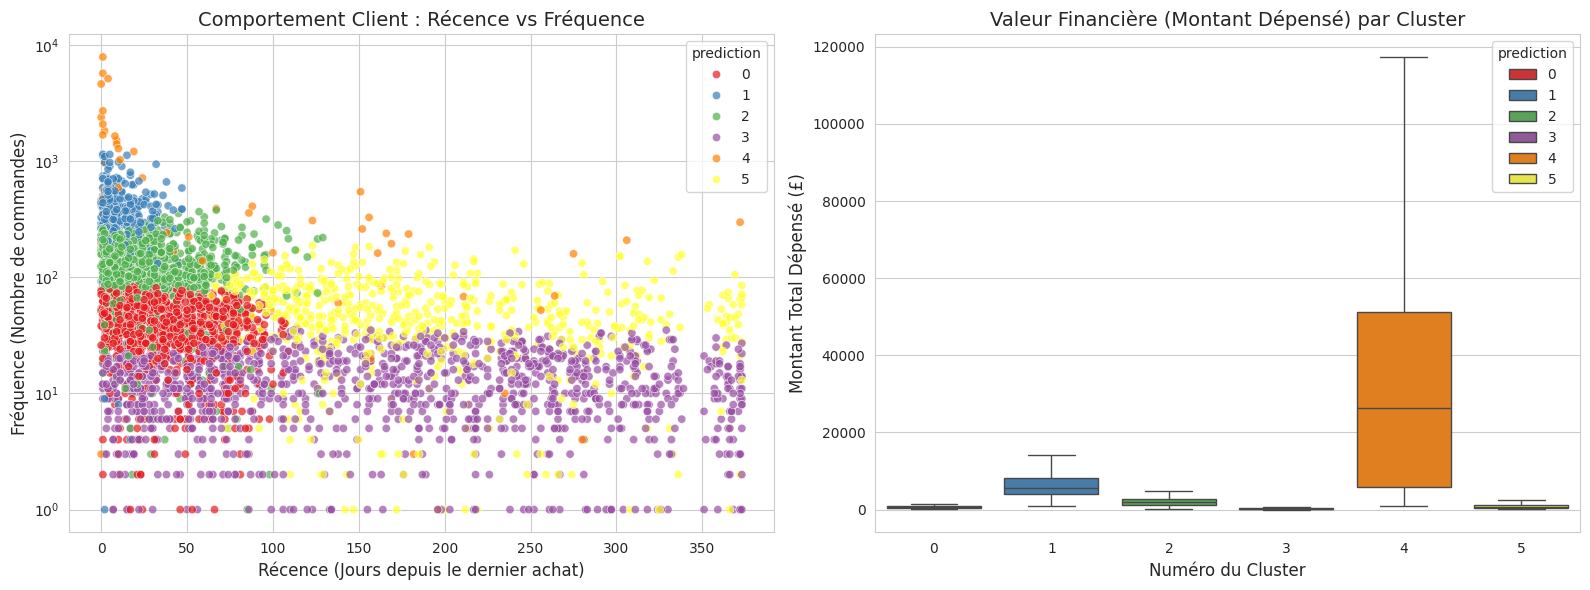


Guide de lecture pour votre présentation (Slides) :
- Graphique Gauche : Identifiez les 'Champions' (en haut à gauche : faible récence, forte fréquence) vs les 'Perdus' (à droite).
- Graphique Droit : Vérifiez la rentabilité. Un cluster peut avoir beaucoup de clients (boxplot large), mais une médiane très basse.


In [ ]:
# ==============================================================================
# 7.1 VISUALISATION AVANCÉE DES CLUSTERS (RFM)
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("--- Génération des graphiques de segmentation ---")

# 1. Transfert des données de Spark (Distribué) vers Pandas (Local)
# On ne sélectionne que les colonnes utiles pour ne pas saturer la RAM
pdf_clusters = predictions.select("Recency", "Frequency", "Monetary", "prediction").toPandas()

# On s'assure que la prédiction est bien vue comme une catégorie (pour les couleurs)
pdf_clusters['prediction'] = pdf_clusters['prediction'].astype('category')

# 2. Configuration esthétique
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ------------------------------------------------------------------------------
# GRAPHIQUE 1 : Nuage de points (Scatter Plot) - Comportement d'achat
# ------------------------------------------------------------------------------
sns.scatterplot(
    data=pdf_clusters,
    x='Recency',
    y='Frequency',
    hue='prediction',
    palette='Set1', # Palette de couleurs contrastées
    alpha=0.7,      # Transparence pour voir les densités
    ax=axes[0]
)
axes[0].set_title('Comportement Client : Récence vs Fréquence', fontsize=14)
axes[0].set_xlabel('Récence (Jours depuis le dernier achat)', fontsize=12)
axes[0].set_ylabel('Fréquence (Nombre de commandes)', fontsize=12)
# Astuce Expert : On met l'axe Y (Fréquence) en échelle logarithmique
# car la majorité des clients commandent 1 fois, mais certains 200 fois.
axes[0].set_yscale('log')

# ------------------------------------------------------------------------------
# GRAPHIQUE 2 : Boîtes à moustaches (Boxplot) - Valeur Financière
# ------------------------------------------------------------------------------
# Le boxplot permet de voir la médiane et la dispersion financière de chaque cluster
sns.boxplot(
    data=pdf_clusters,
    x='prediction',
    y='Monetary',
    hue='prediction',
    palette='Set1',
    showfliers=False, # On masque les outliers extrêmes pour garder un graphique lisible
    ax=axes[1]
)
axes[1].set_title('Valeur Financière (Montant Dépensé) par Cluster', fontsize=14)
axes[1].set_xlabel('Numéro du Cluster', fontsize=12)
axes[1].set_ylabel('Montant Total Dépensé (£)', fontsize=12)

plt.tight_layout()
plt.show()

print("\nGuide de lecture pour votre présentation (Slides) :")
print("- Graphique Gauche : Identifiez les 'Champions' (en haut à gauche : faible récence, forte fréquence) vs les 'Perdus' (à droite).")
print("- Graphique Droit : Vérifiez la rentabilité. Un cluster peut avoir beaucoup de clients (boxplot large), mais une médiane très basse.")

In [ ]:
# ==============================================================================
# 8. NLP & TEXT MINING (CLUSTERING SUR DESCRIPTION)
# ==============================================================================
# Objectif : Utiliser la colonne 'Description' pour catégoriser les produits automatiquement.
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF

print("\n--- 4. Analyse Sémantique des Produits (NLP) ---")
# On ne garde que les descriptions uniques
products_df = df_filtered.select("Description").distinct().dropna()

# Pipeline NLP
tokenizer = Tokenizer(inputCol="Description", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
# TF-IDF pour vectoriser le texte
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=100)
idf = IDF(inputCol="rawFeatures", outputCol="features")
# Clustering simple sur le texte (KMeans)
kmeans_text = KMeans().setK(5).setSeed(1).setFeaturesCol("features")

pipeline_nlp = Pipeline(stages=[tokenizer, remover, hashingTF, idf, kmeans_text])
model_nlp = pipeline_nlp.fit(products_df)
preds_nlp = model_nlp.transform(products_df)

print("Exemples de regroupement de produits par similarité textuelle :")
preds_nlp.select("Description", "prediction").show(5, truncate=False)




--- 4. Analyse Sémantique des Produits (NLP) ---
Exemples de regroupement de produits par similarité textuelle :
+----------------------------------+----------+
|Description                       |prediction|
+----------------------------------+----------+
|10 COLOUR SPACEBOY PEN            |3         |
|SET/10 BLUE POLKADOT PARTY CANDLES|3         |
|POTTING SHED SOW 'N' GROW SET     |3         |
|SET/3 RED GINGHAM ROSE STORAGE BOX|3         |
|MAGNETS PACK OF 4 VINTAGE LABELS  |3         |
+----------------------------------+----------+
only showing top 5 rows


--- Génération des graphiques NLP ---


/tmp/ipython-input-2377879310.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pdf_cluster_counts, x="prediction", y="count", palette="viridis", ax=ax1)


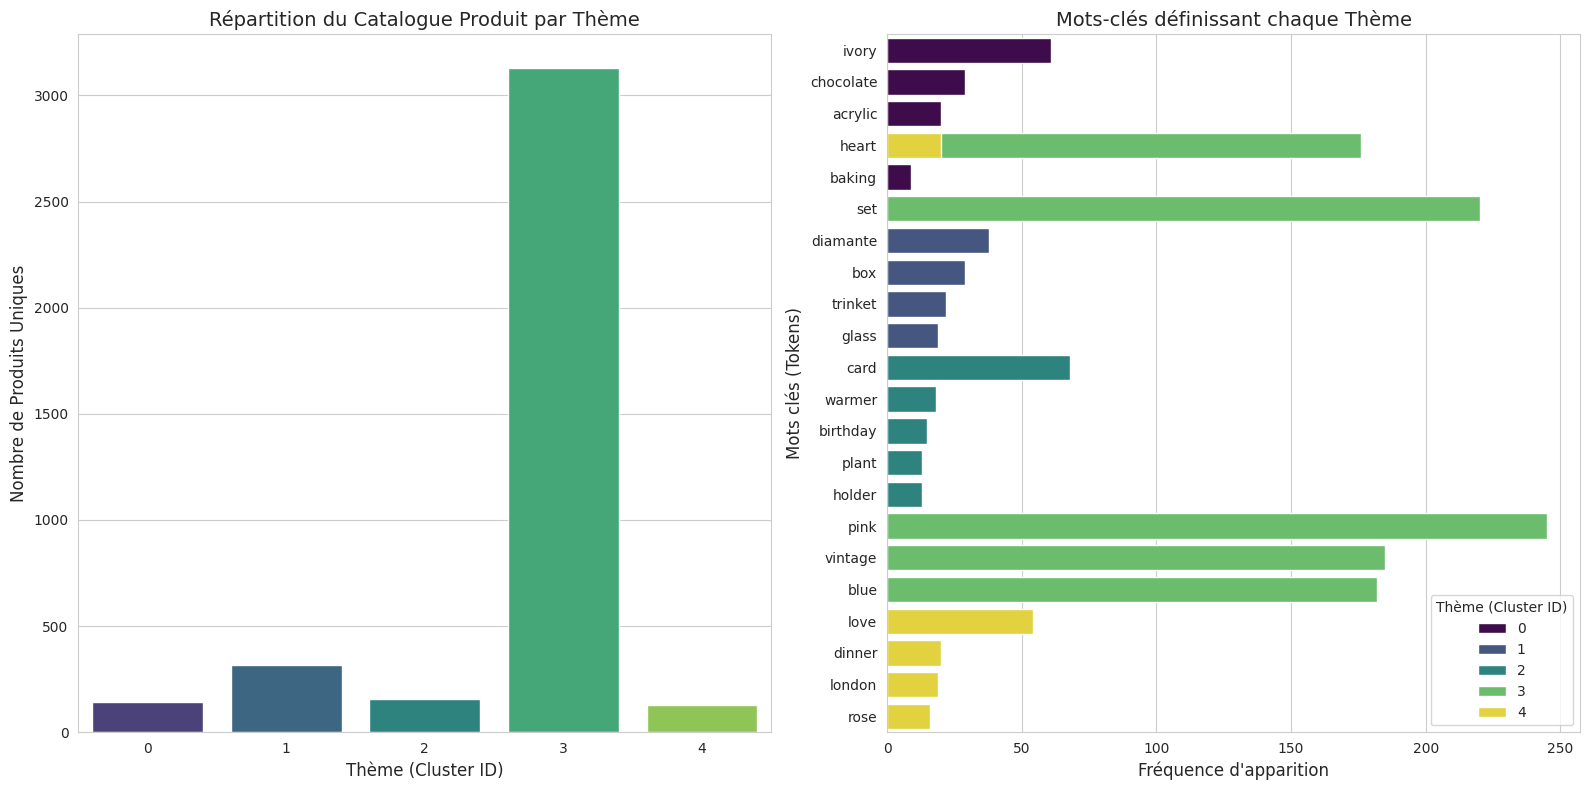

-> Cette technique permet d'étiqueter automatiquement un catalogue e-commerce qui n'a pas de catégories manuelles !


In [ ]:
# ==============================================================================
# 8.1 VISUALISATION DES CLUSTERS SÉMANTIQUES (NLP)
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql.functions import explode, count, col, length
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

print("--- Génération des graphiques NLP ---")

# 1. Distribution des produits par cluster (Combien de produits dans chaque catégorie ?)
pdf_cluster_counts = preds_nlp.groupBy("prediction").count().orderBy("prediction").toPandas()

# 2. Extraction des "Mots Clés" (Top Words) par Cluster
# On "explose" la liste des mots filtrés pour avoir un mot par ligne
exploded_words = preds_nlp.select("prediction", explode("filtered").alias("word"))

# On filtre les mots trop courts (ex: "s", "m") qui n'ont pas de sens
exploded_words = exploded_words.filter(length(col("word")) > 2)

# On compte la fréquence de chaque mot au sein de chaque cluster
word_counts = exploded_words.groupBy("prediction", "word").count()

# On utilise une Window Function pour garder uniquement les 5 mots les plus fréquents par cluster
window_spec = Window.partitionBy("prediction").orderBy(col("count").desc())
top_words_df = word_counts.withColumn("rank", row_number().over(window_spec)) \
                          .filter(col("rank") <= 5) \
                          .toPandas()

# 3. Création de la figure (Dashboard NLP)
sns.set_style("whitegrid")
fig = plt.figure(figsize=(16, 8))

# Graphique de gauche : Taille des clusters
ax1 = plt.subplot(1, 2, 1)
sns.barplot(data=pdf_cluster_counts, x="prediction", y="count", palette="viridis", ax=ax1)
ax1.set_title("Répartition du Catalogue Produit par Thème", fontsize=14)
ax1.set_xlabel("Thème (Cluster ID)", fontsize=12)
ax1.set_ylabel("Nombre de Produits Uniques", fontsize=12)

# Graphique de droite : Top mots par cluster
ax2 = plt.subplot(1, 2, 2)
# On prépare les données pour un graphique à barres horizontales groupé
sns.barplot(
    data=top_words_df,
    x="count",
    y="word",
    hue="prediction",
    dodge=False,
    palette="viridis",
    ax=ax2
)
ax2.set_title("Mots-clés définissant chaque Thème", fontsize=14)
ax2.set_xlabel("Fréquence d'apparition", fontsize=12)
ax2.set_ylabel("Mots clés (Tokens)", fontsize=12)
ax2.legend(title='Thème (Cluster ID)', loc='lower right')

plt.tight_layout()
plt.show()

print("-> Cette technique permet d'étiqueter automatiquement un catalogue e-commerce qui n'a pas de catégories manuelles !")


--- 5. Prédiction Supervisée (Identification des VIPs) ---
--- Évaluation sur le jeu de Test (1236 clients) ---
-> Logistic Regression    : Accuracy = 0.8091 | F1-Score = 0.8081
-> Random Forest          : Accuracy = 0.8309 | F1-Score = 0.8310
-> Gradient Boosted Trees : Accuracy = 0.8317 | F1-Score = 0.8318

🌟 Le meilleur modèle est : Gradient Boosted Trees (F1: 0.8318)

--- Génération de la Matrice de Confusion ---


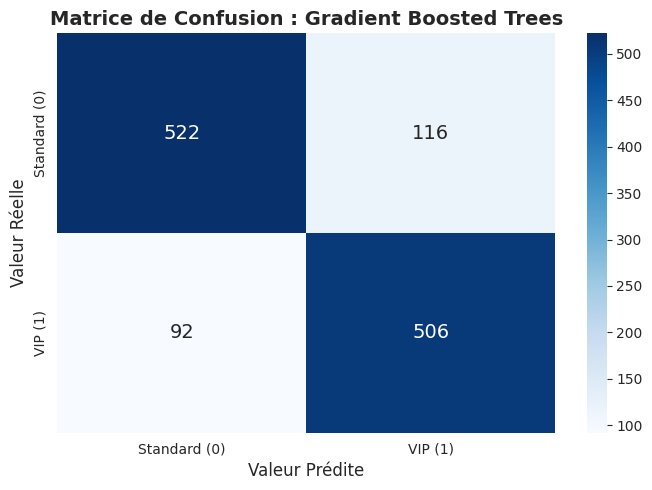

In [ ]:
# ==============================================================================
# 9. MODÉLISATION SUPERVISÉE : PRÉDICTION DE VALEUR (HIGH VALUE)
# ==============================================================================
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql import functions as F
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

print("\n--- 5. Prédiction Supervisée (Identification des VIPs) ---")

# A. Définition de la Target (Cible)
# CORRECTIF EXPERT 1 : Mettre l'erreur relative à 0.0 pour une médiane exacte et stable
median_spend = rfm_df.approxQuantile("Monetary", [0.5], 0.0)[0]

# On joint aussi le pays pour l'utiliser comme feature prédictive
country_df = df_enhanced.groupBy("CustomerID").agg(F.first("Country").alias("Country"))
data_sup = rfm_df.join(country_df, "CustomerID") \
    .withColumn("label", (col("Monetary") > median_spend).cast("integer"))

# B. Feature Engineering Supervisé
indexer = StringIndexer(inputCol="Country", outputCol="CountryIdx", handleInvalid="keep")
encoder = OneHotEncoder(inputCol="CountryIdx", outputCol="CountryVec")
assembler_sup = VectorAssembler(inputCols=["Recency", "Frequency", "CountryVec"], outputCol="features")

pipeline_sup = Pipeline(stages=[indexer, encoder, assembler_sup])

# CORRECTIF EXPERT 2 : Trier par CustomerID AVANT le split pour garantir un ordre déterministe
data_ready = pipeline_sup.fit(data_sup).transform(data_sup).orderBy("CustomerID")

# C. Split Train/Test
# Maintenant, avec l'ordre figé, le seed=42 fonctionnera parfaitement.
train, test = data_ready.randomSplit([0.7, 0.3], seed=42)

# ==============================================================================
# D. ÉVALUATION COMPARATIVE ET MATRICE DE CONFUSION DU MEILLEUR MODÈLE
# ==============================================================================

# CORRECTIF EXPERT 3 : Ajouter un seed à RandomForest et GBT
models = [
    ("Logistic Regression", LogisticRegression(labelCol="label", featuresCol="features")),
    ("Random Forest", RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=50, seed=42)),
    ("Gradient Boosted Trees", GBTClassifier(labelCol="label", featuresCol="features", maxIter=20, seed=42))
]

# Evaluateurs
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", metricName="f1")
evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")

best_f1 = 0
best_model_name = ""
best_predictions = None

print(f"--- Évaluation sur le jeu de Test ({test.count()} clients) ---")

# 1. Boucle d'entraînement et d'évaluation
for name, algo in models:
    model = algo.fit(train)
    preds = model.transform(test)

    f1 = evaluator_f1.evaluate(preds)
    acc = evaluator_acc.evaluate(preds)
    print(f"-> {name:<22} : Accuracy = {acc:.4f} | F1-Score = {f1:.4f}")

    # On garde en mémoire les prédictions du meilleur modèle
    if f1 > best_f1:
        best_f1 = f1
        best_model_name = name
        best_predictions = preds

print(f"\n🌟 Le meilleur modèle est : {best_model_name} (F1: {best_f1:.4f})")

# ==============================================================================
# E. VISUALISATION DE LA MATRICE DE CONFUSION
# ==============================================================================
print("\n--- Génération de la Matrice de Confusion ---")

# On transfère uniquement les colonnes 'label' et 'prediction' vers Pandas
y_true_pred_df = best_predictions.select("label", "prediction").toPandas()

# Calcul de la matrice avec scikit-learn
cm = confusion_matrix(y_true_pred_df['label'], y_true_pred_df['prediction'])

# Tracé graphique avec Seaborn
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Standard (0)", "VIP (1)"],
            yticklabels=["Standard (0)", "VIP (1)"],
            annot_kws={"size": 14})

plt.title(f'Matrice de Confusion : {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('Valeur Réelle', fontsize=12)
plt.xlabel('Valeur Prédite', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# ==============================================================================
# 10. INTELLIGENCE DÉCISIONNELLE (LOGISTIQUE)
# ==============================================================================
# Analyse pour l'ouverture d'un nouvel entrepôt
print("\n--- 6. Recommandation Stratégique (Entrepôt) ---")
warehouse_candidates = df_enhanced.filter(col("Country") != "United Kingdom") \
    .groupBy("Country") \
    .agg(sum("Quantity").alias("Total_Volume"), sum("TotalAmount").alias("Total_Revenue")) \
    .orderBy(F.desc("Total_Volume"))

top_country = warehouse_candidates.first()
print(f"Meilleur candidat hors UK : {top_country['Country']} avec {top_country['Total_Volume']} unités.")

spark.stop()


--- 6. Recommandation Stratégique (Entrepôt) ---
Meilleur candidat hors UK : Netherlands avec 200361 unités.
